# N 皇后问题

## 问题

在 N×N 的棋盘上放置 N 个皇后，使得它们互不攻击（即任意两个皇后不能在同一行、同一列或同一对角线上）。编写程序，对给定的正整数 N（N≥4），输出所有可能的解（或至少一个解），并分析算法效率。

## 思路

使用 回溯法。

定义 queen(col, row) 返回 一个 col 列 row 行的棋盘八皇后解 x 个解法，每个解法是一个 row 个元素长的数组，其中每个数字的范围为 [0, col-1] 表示目前每一行的棋子的列号

则 queen(n, i) 的伪代码如下

定义 结果数组 result

先得到 queen(n, i-1) 的解法 sols

for sol in sols:

    for step in range(col):

        if check(sol, step):

            result.append(sol + step)

返回结果数组 result

## 代码实现

### 导入需要使用的包

In [2]:
from line_profiler import profile
import matplotlib.pyplot as plt
import time

### 最普通的回溯法版本

In [3]:
# 检查在当前已经存在的棋子情况下，step是否合法
def check(sol, step):
    row = len(sol) # 已经走了的行数
    col = step     # 试图走的列号
    for i, j in enumerate(sol): # 遍历所有已经走了的棋子
        if col == j or abs(row - i) == abs(col - j): # 如果会冲突
            return False
    return True

In [4]:
# 核心回溯算法
@profile # 方便后面进行代码行级速度比较
def queen(col, row):
    if row == 0:
        return [[]]
    result = []
    sols = queen(col, row-1)
    for sol in sols:
        for step in range(col):
            if check(sol, step):
                result.append(sol + [step])

    return result

In [5]:
# 绘制字符画结果
def show(sol):
    n = len(sol)
    for row, col in enumerate(sol):
        for j in range(n):
            if col == j:
                print("Q", end=' ')
            else:
                print("#", end=' ')
        print()
    print()

#### 测试

In [6]:
# 测试
def test(n):
    sols = queen(n, n)
    print(f"Total count of solutions: {len(sols)}")
    # 只显示第一个解防止太多输出
    show(sols[0])

In [7]:
# 四皇后
test(4)
# 八皇后
test(8)

Total count of solutions: 2
# Q # # 
# # # Q 
Q # # # 
# # Q # 

Total count of solutions: 92
Q # # # # # # # 
# # # # Q # # # 
# # # # # # # Q 
# # # # # Q # # 
# # Q # # # # # 
# # # # # # Q # 
# Q # # # # # # 
# # # Q # # # # 



### 位运算加剪枝优化

使用位运算可以大大提高效率：
1. 使用二进制位表示每一行/列/对角线是否被占用
2. 使用位运算代替数组操作和循环判断
3. 使用剪枝策略减少搜索空间

In [8]:
@profile
def solve_n_queens_bits(n):
    """
    使用位运算解决N皇后问题
    
    参数:
        n: 棋盘大小和皇后数量
        
    返回:
        solutions: 所有可能的解法列表
    """
    solutions = []
    
    def backtrack(row, cols, diag1, diag2, current_solution):
        """
        回溯函数 - 使用位运算处理约束条件
        
        参数:
            row: 当前处理的行号
            cols: 列的占用情况(二进制表示)
            diag1: 主对角线占用情况(二进制表示)
            diag2: 副对角线占用情况(二进制表示)
            current_solution: 当前解法
        """
        if row == n:  # 找到一个解
            solutions.append(current_solution[:])
            return
        
        # 获取所有可用位置
        # (1 << n) - 1 创建n位全1的掩码
        # ~(cols | diag1 | diag2) 获取所有未被占用的位置
        # & ((1 << n) - 1) 确保只考虑n个位置
        available_positions = ~(cols | diag1 | diag2) & ((1 << n) - 1)
        
        # 当还有可用位置时继续尝试
        while available_positions:
            # 获取最右边的1(即最右边的可用位置)
            pos = available_positions & (-available_positions)
            # 获取这个位置对应的列号
            col = bin(pos - 1).count('1')
            
            # 更新当前解
            current_solution[row] = col
            
            # 递归到下一行
            # 更新约束条件:
            # cols | pos: 更新列的占用情况
            # (diag1 | pos) << 1: 更新主对角线占用情况
            # (diag2 | pos) >> 1: 更新副对角线占用情况
            backtrack(row + 1,
                     cols | pos,
                     (diag1 | pos) << 1,
                     (diag2 | pos) >> 1,
                     current_solution)
            
            # 移除最右边的1，尝试下一个位置
            available_positions &= (available_positions - 1)
    
    # 初始化一个解
    initial_solution = [0] * n
    # 从第0行开始回溯
    backtrack(0, 0, 0, 0, initial_solution)
    
    return solutions

#### 测试

In [9]:
def test_bits(n):
    """
    测试位运算优化版本的N皇后算法
    
    参数:
        n: 棋盘大小和皇后数量
    """
    sols = solve_n_queens_bits(n)
    print(f"Total count of solutions: {len(sols)}")
    # 只显示第一个解防止太多输出
    show(sols[0])

In [10]:
test_bits(4)

test_bits(8)

Total count of solutions: 2
# Q # # 
# # # Q 
Q # # # 
# # Q # 

Total count of solutions: 92
Q # # # # # # # 
# # # # Q # # # 
# # # # # # # Q 
# # # # # Q # # 
# # Q # # # # # 
# # # # # # Q # 
# Q # # # # # # 
# # # Q # # # # 



### 性能比较

In [11]:
# 对比原始版本和位运算优化版本的性能
def compare_performance(max_n=12):
    import time
    print("比较原始版本和位运算优化版本的性能：")
    print("\nN\t原始版本(s)\t位运算版本(s)")
    print("-" * 40)
    
    for n in range(4, max_n+1):
        # 测试原始版本
        start = time.time()
        queen(n, n)
        original_time = time.time() - start
        
        # 测试位运算版本
        start = time.time()
        solve_n_queens_bits(n)
        optimized_time = time.time() - start
        
        print(f"{n}\t{original_time:.6f}\t{optimized_time:.6f}")

compare_performance(12)

比较原始版本和位运算优化版本的性能：

N	原始版本(s)	位运算版本(s)
----------------------------------------
4	0.000000	0.000000
5	0.000000	0.000000
6	0.000000	0.000000
7	0.003088	0.000000
8	0.005990	0.001001
9	0.033464	0.004973
10	0.189338	0.015727
11	0.853005	0.125798
12	5.357095	0.446396


代码行级性能分析

In [12]:
%reload_ext line_profiler
%lprun -f queen queen(12, 12)

Timer unit: 1e-07 s

Total time: 36.1562 s
File: C:\Users\18499\AppData\Local\Temp\ipykernel_26524\389296870.py
Function: queen at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @profile # 方便后面进行代码行级速度比较
     3                                           def queen(col, row):
     4        13         41.0      3.2      0.0      if row == 0:
     5         1          4.0      4.0      0.0          return [[]]
     6        12         37.0      3.1      0.0      result = []
     7        12         67.0      5.6      0.0      sols = queen(col, row-1)
     8    842001    1470622.0      1.7      0.4      for sol in sols:
     9  10945857   22347544.0      2.0      6.2          for step in range(col):
    10  10103868  334031933.0     33.1     92.4              if check(sol, step):
    11    856188    3711994.0      4.3      1.0                  result.append(sol + [step])
    12                                           

可以看到当数量比较多的时候大约有10倍的性能提升

原因就在于使用位运算标记棋盘占用情况不需要通过遍历就能直接知道当前还可以放置棋子的位置，省去了check()函数消耗的大量时间。

## 实验分析

### 时间复杂度理论分析

最普通的回溯法本质上就是在搜索一个n叉树，寻找所有合法的解。

所以时间复杂度是 $O(n^n)$

### 时间增长曲线

In [13]:
def time_stats(max_n):
    import time
    stats = []
    for i in range(1, max_n+1):
        start_time = time.time()
        queen(i, i)
        end_time = time.time()
        stats.append(end_time - start_time)
    return stats

In [20]:
time_stats_data = time_stats(12)
pow_nn = [n**n for n in range(12)]

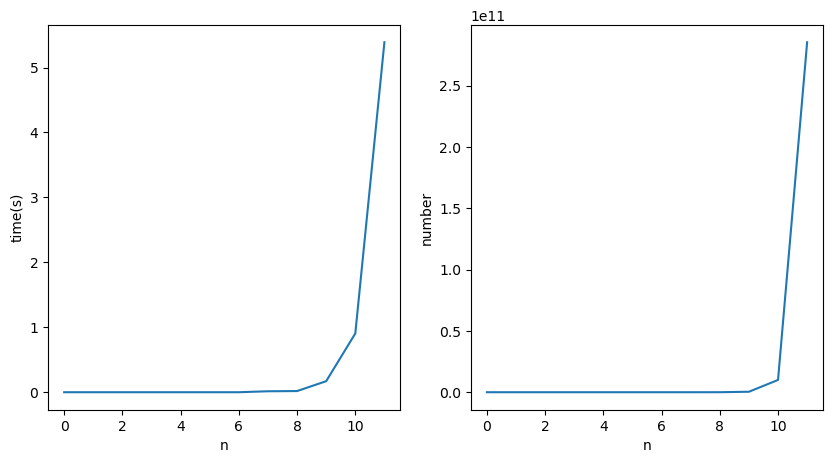

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.ylabel("time(s)")
plt.xlabel("n")
plt.plot(time_stats_data)
plt.subplot(122)
plt.ylabel("number")
plt.xlabel("n")
plt.plot(pow_nn)
plt.show()